In [1]:
# What i changed  LeakyRelu 0.2 -> 0.4 and dropout increased to .5 ,  took out 512 first fully connected layer

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import joblib

In [3]:

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [5]:
class BhargavaCube3D(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], output_dim=3, dropout_rate=0.5):
        super(BhargavaCube3D, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.SiLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.encoder = nn.Sequential(*layers)

        self.form1 = nn.Parameter(torch.randn(3, 3), requires_grad=True)
        self.form2 = nn.Parameter(torch.randn(3, 3), requires_grad=True)
        self.form3 = nn.Parameter(torch.randn(3, 3), requires_grad=True)
        self._make_symmetric()

    def _make_symmetric(self):
        with torch.no_grad():
            self.form1.data.copy_(0.5 * (self.form1.data + self.form1.data.T))
            self.form2.data.copy_(0.5 * (self.form2.data + self.form2.data.T))
            self.form3.data.copy_(0.5 * (self.form3.data + self.form3.data.T))

    def forward(self, x):
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)

        z = self.encoder(x)
        batch_size = z.size(0)
        self._make_symmetric()
        z_reshaped = z.unsqueeze(2)

        tmp1 = torch.bmm(self.form1.expand(batch_size, -1, -1), z_reshaped)
        qf1 = torch.bmm(z_reshaped.transpose(1, 2), tmp1).view(batch_size, -1)

        tmp2 = torch.bmm(self.form2.expand(batch_size, -1, -1), z_reshaped)
        qf2 = torch.bmm(z_reshaped.transpose(1, 2), tmp2).view(batch_size, -1)

        tmp3 = torch.bmm(self.form3.expand(batch_size, -1, -1), z_reshaped)
        qf3 = torch.bmm(z_reshaped.transpose(1, 2), tmp3).view(batch_size, -1)

        return z, qf1, qf2, qf3

    def get_quadratic_forms(self):
        return self.form1.detach(), self.form2.detach(), self.form3.detach()

    def compute_bhargava_relations(self, z):
      batch_size = z.size(0)
      z_reshaped = z.unsqueeze(2)

      tmp1 = torch.bmm(self.form1.expand(batch_size, -1, -1), z_reshaped)
      qf1 = torch.bmm(z_reshaped.transpose(1, 2), tmp1).view(batch_size, -1)

      tmp2 = torch.bmm(self.form2.expand(batch_size, -1, -1), z_reshaped)
      qf2 = torch.bmm(z_reshaped.transpose(1, 2), tmp2).view(batch_size, -1)

      tmp3 = torch.bmm(self.form3.expand(batch_size, -1, -1), z_reshaped)
      qf3 = torch.bmm(z_reshaped.transpose(1, 2), tmp3).view(batch_size, -1)

      error = qf1 * qf2 - qf3**2
      return torch.mean(error**2)


In [6]:
class Classifier3D(nn.Module):
    """
    Classifier that operates on the 3D Bhargava cube representation.
    """
    def __init__(self, input_dim=9, hidden_dims=[64, 32], num_classes=10, dropout_rate=0.5):
        super(Classifier3D, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.SiLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, num_classes))

        self.classifier = nn.Sequential(*layers)

    def forward(self, z):
        return self.classifier(z)


In [7]:
class BCMEM3D(nn.Module):
    """
    Complete 3D Bhargava Cube Manifold Embedded Model (BCMEM3D).
    Combines the Bhargava cube encoder and classifier.
    """
    def __init__(self, input_dim, hidden_dims_encoder=[256, 128, 64],
                 hidden_dims_classifier=[64, 32], cube_dim=3,
                 num_classes=10, dropout_rate=0.5):
        super(BCMEM3D, self).__init__()

        # 3D Bhargava Cube encoder
        self.encoder = BhargavaCube3D(
            input_dim=input_dim,
            hidden_dims=hidden_dims_encoder,
            output_dim=cube_dim,
            dropout_rate=dropout_rate
        )

        # Classifier operating on the 3D representation
        self.classifier = Classifier3D(
            input_dim=cube_dim,
            hidden_dims=hidden_dims_classifier,
            num_classes=num_classes,
            dropout_rate=dropout_rate
        )

    def forward(self, x):
        z, qf1, qf2, qf3 = self.encoder(x)
        qf_all = torch.cat([qf1, qf2, qf3], dim=1)
        output = self.classifier(qf_all)
        return output, z, qf_all

    def get_latent(self, x):
        z, _ = self.encoder(x)
        return z



In [8]:
# Set up the model for MNIST
def setup_mnist_model_3d():
    # MNIST dataset setup with data augmentation
    transform_train = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize 3D Bhargava cube model
    input_dim = 28 * 28  # MNIST image size
    model = BCMEM3D(
        input_dim=input_dim,
        hidden_dims_encoder=[512, 256, 128, 64],
        hidden_dims_classifier=[512, 512, 512, 128, 64],
        cube_dim=3,  # 3D space
        num_classes=10,
        dropout_rate=0.1
    ).to(device)

    return model, train_loader, test_loader


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_bcmem_3d(model, train_loader, test_loader, num_epochs=30, initial_lr=0.001):
    encoder_params = list(model.encoder.parameters())
    classifier_params = list(model.classifier.parameters())

    optimizer = optim.AdamW([
        {'params': encoder_params, 'lr': initial_lr},
        {'params': classifier_params, 'lr': initial_lr}
    ], weight_decay=1e-5)


    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, latent, qf_values = model(images)

            clf_loss = F.cross_entropy(outputs, labels, label_smoothing=0.05)
            bhargava_relation_error = model.encoder.compute_bhargava_relations(latent)
            loss = clf_loss + 0.01 * bhargava_relation_error

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if (batch_idx + 1) % 100 == 0:
                lr_value = scheduler.get_last_lr()
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, "
                      f"Loss: {loss.item():.4f}, Bhargava Error: {bhargava_relation_error.item():.4f}, LR: {lr_value[0]:.12f}")

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_correct / train_total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _, _ = model(images)
                loss = F.cross_entropy(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = test_correct / test_total
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)
        scheduler.step(epoch_test_loss)

        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            torch.save(model.state_dict(), 'best_bcmem_3d_model.pth')

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.6f}, Train Acc: {epoch_train_acc:.6f}, "
              f"Test Loss: {epoch_test_loss:.6f}, Test Acc: {epoch_test_acc:.6f}, Best Acc: {best_acc:.6f}, LR: {lr_value[0]:.12f}")
        if epoch_test_acc > 0.995:
            print(f"Early stopping at epoch {epoch+1}.")
            break

    plot_loss_curves(train_losses, test_losses)
    plot_loss_curves(train_accs,test_accs)
    try:
        model.load_state_dict(torch.load('best_bcmem_3d_model.pth'))
    except:
        print("Best model load failed; using current state.")

    return model, {'train_losses': train_losses, 'test_losses': test_losses,
                  'train_accs': train_accs, 'test_accs': test_accs}


def plot_loss_curves(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


def visualize_3d_bhargava_cube(model, test_loader, num_samples=1000):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, target in test_loader:
            if len(embeddings) * images.size(0) >= num_samples:
                break
            images = images.to(device)
            _, latent, _ = model(images)
            embeddings.append(latent.cpu().numpy())
            labels.append(target.numpy())

    embeddings = np.concatenate(embeddings, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for digit in range(10):
        mask = labels == digit
        ax.scatter(embeddings[mask, 0], embeddings[mask, 1], embeddings[mask, 2], label=f'Digit {digit}')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Bhargava Cube Embeddings')
    ax.legend()

    plt.tight_layout()
    plt.savefig('bhargava_cube_3d_visualization.png')
    plt.show()

    form1, form2, form3 = model.encoder.get_quadratic_forms()

    print("Quadratic Form 1:\n", form1.cpu().numpy())
    print("\nQuadratic Form 2:\n", form2.cpu().numpy())
    print("\nQuadratic Form 3:\n", form3.cpu().numpy())

    return embeddings, labels


100%|██████████| 9.91M/9.91M [00:00<00:00, 53.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.57MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.72MB/s]

Total parameters: 1181928
Trainable parameters: 1181928


Epoch 1/200, Batch 100/235, Loss: 1.4900, Bhargava Error: 4.1010, LR: 0.001000000000
Epoch 1/200, Batch 200/235, Loss: 1.0251, Bhargava Error: 1.8953, LR: 0.001000000000
Epoch 1/200: Train Loss: 1.615497, Train Acc: 0.503033, Test Loss: 0.595510, Test Acc: 0.818000, Best Acc: 0.818000, LR: 0.001000000000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/200, Batch 100/235, Loss: 0.7943, Bhargava Error: 0.3485, LR: 0.000999978147
Epoch 2/200, Batch 200/235, Loss: 0.8010, Bhargava Error: 0.2877, LR: 0.000999978147
Epoch 2/200: Train Loss: 0.802131, Train Acc: 0.812917, Test Loss: 0.266160, Test Acc: 0.931400, Best Acc: 0.931400, LR: 0.000999978147
Epoch 3/200, Batch 100/235, Loss: 0.6199, Bhargava Error: 0.7153, LR: 0.000999995635
Epoch 3/200, Batch 200/235, Loss: 0.5698, Bhargava Error: 0.3110, LR: 0.000999995635
Epoch 3/200: Train Loss: 0.635604, Train Acc: 0.879967, Test Loss: 0.217527, Test Acc: 0.945600, Best Acc: 0.945600, LR: 0.000999995635
Epoch 4/200, Batch 100/235, Loss: 0.5128, Bhargava Error: 0.1219, LR: 0.000999997084
Epoch 4/200, Batch 200/235, Loss: 0.4877, Bhargava Error: 0.1756, LR: 0.000999997084
Epoch 4/200: Train Loss: 0.557335, Train Acc: 0.908400, Test Loss: 0.179787, Test Acc: 0.957600, Best Acc: 0.957600, LR: 0.000999997084
Epoch 5/200, Batch 100/235, Loss: 0.4274, Bhargava Error: 0.0756, LR: 0.0009999980

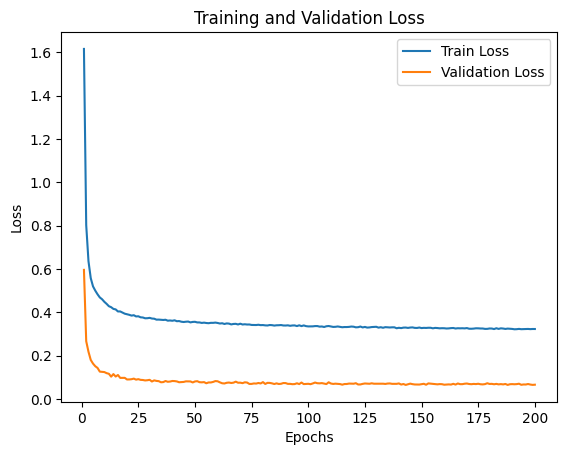

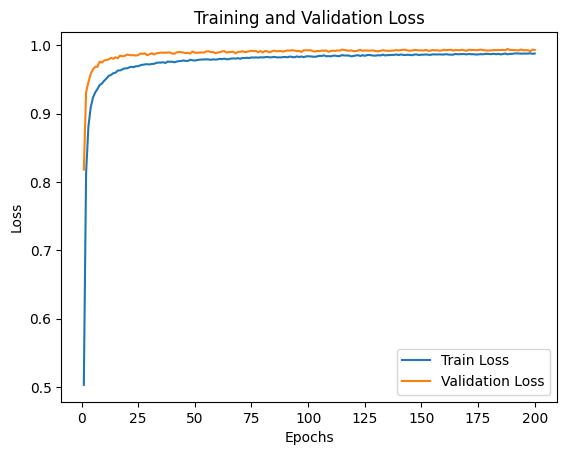

Test Accuracy: 99.46%


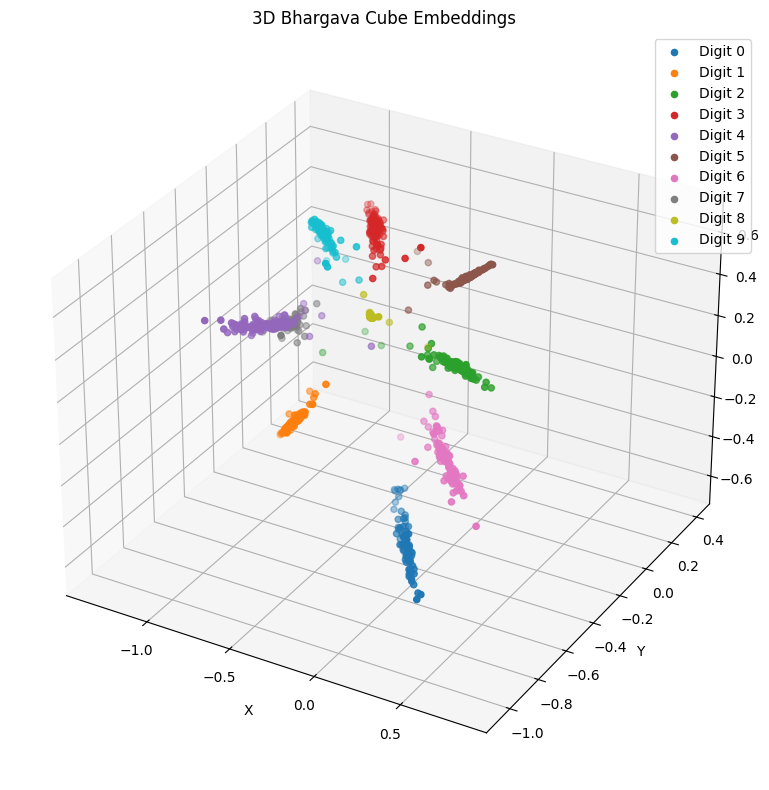

Quadratic Form 1:
 [[-0.36117452 -0.02930912  0.31984425]
 [-0.02930912  1.2914808   0.6880931 ]
 [ 0.31984425  0.6880931   0.26794294]]

Quadratic Form 2:
 [[-0.20121194 -0.73842186  0.0640225 ]
 [-0.73842186 -0.5048436   0.99555933]
 [ 0.0640225   0.99555933  0.24611068]]

Quadratic Form 3:
 [[-0.08302853  0.3383995  -0.21263747]
 [ 0.3383995   0.3152539   0.5215765 ]
 [-0.21263747  0.5215765   1.0984334 ]]
3D visualization created successfully!


In [10]:
# Example usage
if __name__ == "__main__":
    try:
        # Set up model for MNIST
        model, train_loader, test_loader = setup_mnist_model_3d()

        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params}")
        print(f"Trainable parameters: {trainable_params}")

        # Train the model
        trained_model, metrics = train_bcmem_3d(model, train_loader, test_loader, num_epochs=200, initial_lr=0.001)

        # Evaluate on test set
        trained_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _, _ = trained_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy}%")

        # Visualize the 3D Bhargava cube
        try:
            import matplotlib
            import matplotlib.pyplot as plt
            from mpl_toolkits.mplot3d import Axes3D

            embeddings, labels = visualize_3d_bhargava_cube(trained_model, test_loader)
            print("3D visualization created successfully!")
        except ImportError:
            print("Matplotlib is required for visualization.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [11]:
import joblib
file_name = 'bcmem64_200e_v9.pkl'
joblib.dump(model, file_name)

['bcmem64_200e_v9.pkl']

In [12]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 1181928
Trainable parameters: 1181928


In [13]:
train

NameError: name 'train' is not defined